In [159]:
# conda install scikit-learn

import pandas as pd
import numpy as np
import re

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow.keras import layers

In [160]:
titanic_dataset_dir = '../titanic_dataset/'
for dirname, _, filenames in os.walk(titanic_dataset_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../titanic_dataset/test.csv
../titanic_dataset/train.csv
../titanic_dataset/gender_submission.csv


In [161]:
from sklearn.model_selection import train_test_split

train_data = pd.read_csv(titanic_dataset_dir + "/train.csv")

train_data, validation_data = train_test_split(train_data, test_size=0.2)

test_data = pd.read_csv(titanic_dataset_dir + "/test.csv")
train_data.head()

# Generate new features
full_data = [train_data, validation_data, test_data]

for data in full_data:
    data['Has_Cabin'] = data['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
    
    data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
    
    data['IsAlone'] = 0
    data.loc[data['FamilySize'] == 1, 'IsAlone'] = 1


print(len(train_data), 'train examples')
print(len(validation_data), 'validation examples')
print(len(test_data), 'test examples')

712 train examples
179 validation examples
418 test examples


In [162]:
# Impute Null Values
train_data_copy, validation_data_copy, test_data_copy = train_data.copy(), validation_data.copy(), test_data.copy()
datasets = [train_data_copy, validation_data_copy, test_data_copy]

for ds in datasets:
    ds['Sex'].replace([0,1],['female','male'],inplace=True)
    
    age_mean = np.mean(ds['Age'],axis=0)
    ds['Age'] = ds['Age'].fillna(age_mean)

    fare_mean = np.mean(ds['Fare'],axis=0)
    ds['Fare'] = ds['Fare'].fillna(fare_mean)

    ds['Embarked'] = ds['Embarked'].fillna("S")
    ds['Embarked'] = ds['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)

In [163]:
features = ["Pclass", "Sex", "SibSp", "Parch","Fare", "Age", "Embarked", "Has_Cabin", "FamilySize", "IsAlone"]

labels = np.asarray(train_data_copy["Survived"])
validation_labels = np.asarray(validation_data_copy["Survived"])

featurized_dataset = pd.get_dummies(train_data_copy[features])
validation_featurized_dataset = pd.get_dummies(validation_data_copy[features])
test_featurized_dataset = pd.get_dummies(test_data_copy[features])

from sklearn import preprocessing


def scale_dataframe(df: pd.DataFrame, strategy: str) -> pd.DataFrame:
    x = df.values #returns a numpy array

    if strategy == "MinMax":
        scaler = preprocessing.MinMaxScaler()
    elif strategy == "Standard":
        scaler = preprocessing.StandardScaler()
    else: 
        raise NotImplementedError("Strategy Not Supported")

    x_scaled = scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled)
    return df

featurized_dataset = np.asarray(scale_dataframe(featurized_dataset, "Standard"))
validation_featurized_dataset = np.asarray(scale_dataframe(validation_featurized_dataset, "Standard"))
test_featurized_dataset = np.asarray(scale_dataframe(test_featurized_dataset, "Standard"))

Train on 712 samples, validate on 179 samples
Epoch 1/100
712/712 [==============================] - 1s 2ms/sample - loss: 0.8451 - accuracy: 0.6222 - val_loss: 0.7980 - val_accuracy: 0.5866
Epoch 2/100
712/712 [==============================] - 0s 138us/sample - loss: 0.7933 - accuracy: 0.6601 - val_loss: 0.7581 - val_accuracy: 0.6369
Epoch 3/100
712/712 [==============================] - 0s 135us/sample - loss: 0.7549 - accuracy: 0.6994 - val_loss: 0.7328 - val_accuracy: 0.6983
Epoch 4/100
712/712 [==============================] - 0s 131us/sample - loss: 0.7319 - accuracy: 0.7654 - val_loss: 0.7184 - val_accuracy: 0.7486
Epoch 5/100
712/712 [==============================] - 0s 142us/sample - loss: 0.7177 - accuracy: 0.7907 - val_loss: 0.7111 - val_accuracy: 0.7542
Epoch 6/100
712/712 [==============================] - 0s 135us/sample - loss: 0.7086 - accuracy: 0.8020 - val_loss: 0.7049 - val_accuracy: 0.7598
Epoch 7/100
712/712 [==============================] - 0s 137us/sample - l

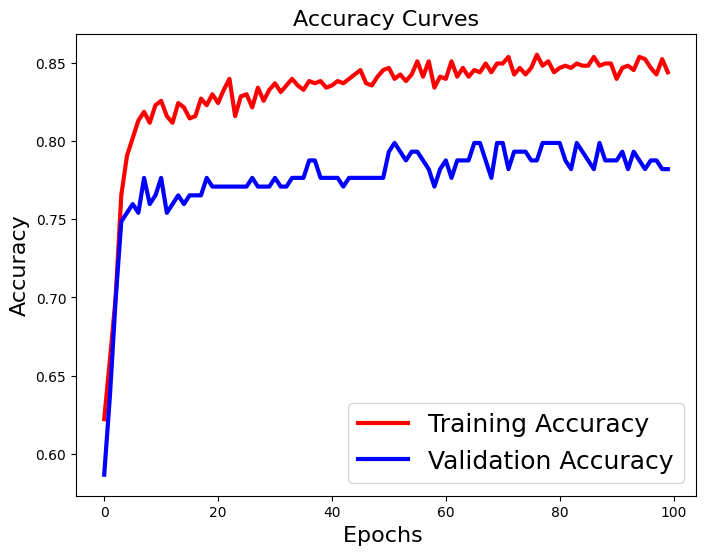

In [164]:
import matplotlib.pyplot as plt # visualizations

model = tf.keras.Sequential([ 
    tf.keras.layers.Dense(64, 
                          kernel_initializer = 'glorot_normal', 
                          #bias_initializer = 'truncated_normal', 
                          kernel_regularizer = tf.keras.regularizers.l2(0.001), 
                          bias_regularizer = tf.keras.regularizers.l2(0.01), 
                          activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, 
                          kernel_initializer = 'glorot_normal',
                          #bias_initializer = 'truncated_normal', 
                          kernel_regularizer = tf.keras.regularizers.l2(0.001), 
                          bias_regularizer = tf.keras.regularizers.l2(0.01), 
                          activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, 
                          kernel_initializer = 'glorot_normal',
                          #bias_initializer = 'truncated_normal', 
                          kernel_regularizer = tf.keras.regularizers.l2(0.001), 
                          bias_regularizer = tf.keras.regularizers.l2(0.01), 
                          activation = 'relu'),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, 
                          kernel_initializer = 'glorot_normal', 
                          #bias_initializer = 'truncated_normal', 
                          kernel_regularizer = tf.keras.regularizers.l2(0.001), 
                          bias_regularizer = tf.keras.regularizers.l2(0.01), 
                          activation = 'sigmoid')
])

model.compile(optimizer='adam', 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=['accuracy'])

history = model.fit(featurized_dataset, labels, epochs=100, validation_data=(validation_featurized_dataset, validation_labels))
valid_loss, valid_acc = model.evaluate(validation_featurized_dataset, validation_labels, verbose=2)
print('\nTest accuracy:', valid_acc)

plt.figure(figsize = [8, 6])
plt.plot(history.history['accuracy'], 'r', linewidth = 3.0)
plt.plot(history.history['val_accuracy'], 'b', linewidth = 3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize = 18)
plt.xlabel('Epochs ', fontsize = 16)
plt.ylabel('Accuracy', fontsize = 16)
plt.title('Accuracy Curves', fontsize = 16)
plt.show()

In [165]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             multiple                  768       
_________________________________________________________________
dropout_23 (Dropout)         multiple                  0         
_________________________________________________________________
dense_53 (Dense)             multiple                  2080      
_________________________________________________________________
dropout_24 (Dropout)         multiple                  0         
_________________________________________________________________
dense_54 (Dense)             multiple                  528       
_________________________________________________________________
dense_55 (Dense)             multiple                  17        
Total params: 3,393
Trainable params: 3,393
Non-trainable params: 0
___________________________________________________

In [166]:
predictions = model.predict(validation_featurized_dataset)
output = pd.DataFrame({'PassengerId': validation_data.PassengerId.tolist(), 'Survived': predictions.tolist()})
predictions_zero_one = np.where(predictions > 0.5, 1, 0)
output = pd.DataFrame({'Label': validation_data.Survived.tolist(), 'Prediction': predictions_zero_one.reshape(-1).tolist()})
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(output['Prediction'], output['Label'])

acc = np.sum(conf_mat.diagonal()) / np.sum(conf_mat)
acc

0.7821229050279329

In [167]:
test_predictions = model.predict(test_featurized_dataset)
test_predictions_zero_one = np.where(test_predictions > 0.5, 1, 0)
output = pd.DataFrame({'PassengerId': test_data.PassengerId.tolist(), 'Survived': test_predictions_zero_one.reshape(-1).tolist()})

output.to_csv('submission_tf.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
